In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'PcmPy')
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
list_sn = su.get_list_sn()

---

In [11]:
h = 'L'
list_roi = simage.get_list_roi()

---

In [12]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [13]:
result = {'subj':[], 'roi':[], 'r':[], 'r_corr':[]}
for rr, roi in enumerate(list_roi):
    print(roi)
    Y = []
    for ss, sn in enumerate(tqdm(list_sn)):
        subj = 'S'+sn
        fname = join(dir_glm,'pwbeta.%s.%s.%drois.npz'%(h,subj,len(list_roi)))
        with np.load(fname, allow_pickle=True) as npz:
            dataset = npz['dataset']
            cond_vec = npz['cond_vec']
            part_vec = npz['part_vec']
            
        obs_des = {'cond_vec': cond_vec, 'part_vec':part_vec}
        Y.append(
            pcm.dataset.Dataset(
                measurements=dataset[rr],
                obs_descriptors=obs_des
            )
        )

    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        data = Y[ss].measurements
        cond_vec = Y[ss].obs_descriptors['cond_vec']
        part_vec = Y[ss].obs_descriptors['part_vec']
        r_corr = np.mean(
            rel.within_subj_loo(data, cond_vec, part_vec, separate='none', subtract_mean=True)
        )
        r = rel.within_subj(data, cond_vec, part_vec, separate='none', subtract_mean=True)[0]
        result['subj'].append(subj)
        result['roi'].append(roi)
        result['r'].append(r)
        result['r_corr'].append(r_corr)

df = pd.DataFrame(result)
del result

S1


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.65it/s]


M1


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.52it/s]


PMd


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.71it/s]


PMv


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.60it/s]


SMA


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


V1


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


SPLa


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.61it/s]


SPLp


100%|███████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.62it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'glm_1')

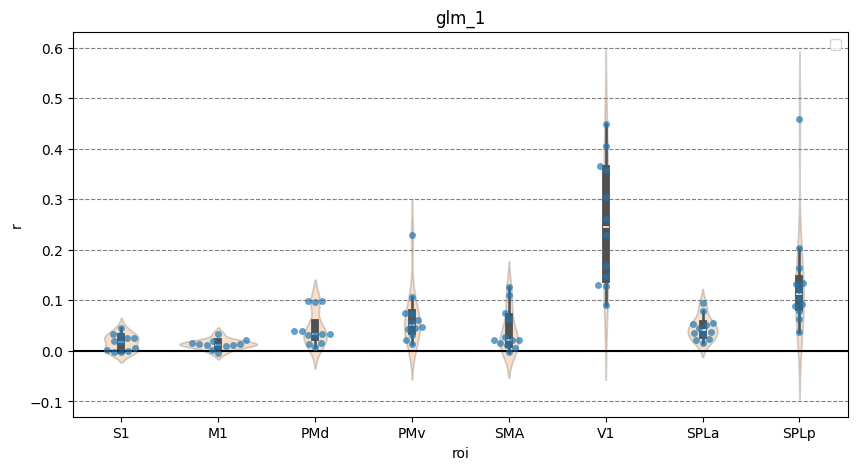

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

y = 'r'
sns.swarmplot(
    data=df,
    x='roi', y=y,
    alpha=0.7,
    ax=ax
)
sns.violinplot(
    data=df,
    x='roi', y=y,
    alpha=0.25,
    ax=ax
)
ax.grid(axis='y', linestyle='--', color='gray')
ax.legend()
ax.axhline(y=0, color='black')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel(r'%s'%y)
ax.set_title('glm_%d'%glm)

S1 4.527e-03(**)
M1 7.552e-04(***)
PMd 7.609e-04(***)
PMv 1.857e-03(**)
SMA 6.047e-03(**)
V1 1.779e-05(****)
SPLa 2.948e-05(****)
SPLp 1.011e-03(**)


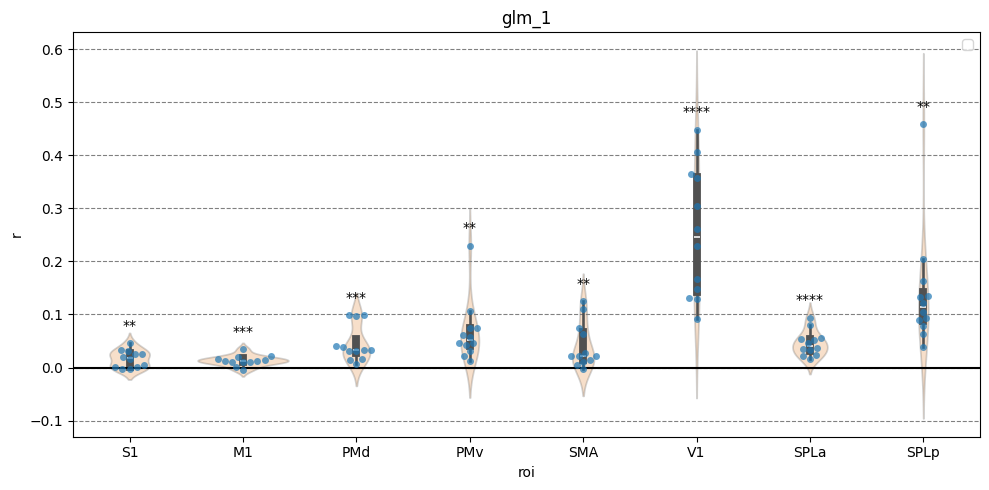

In [17]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = df[df.roi==roi][y].astype(float)
    tval, pval = ttest_1samp(a, popmean=0)
    if pval < 0.05:
        print(roi, '%.3e(%s)'%(pval,su.convert_pval_to_star(pval)))
        ax.text(
            x=ii, y=a.max() + dy,
            s=su.convert_pval_to_star(pval), fontsize=10,
            ha='center', va='bottom'
        )
fig.tight_layout()
fig

---